# Inference mode for CLIP experiments

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import load
import mlflow

In [151]:
state_dc = load('/Users/sebastianalejandrosarastizambonino/Documents/projects/CLIP_Pytorch/src/best_model.pth')

/var/folders/t1/1g6kqykj7pjbt9l4nwcplwz00000gn/T/ipykernel_10642/3602835336.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dc = load('/Users/sebastianalejandrosar

Load the CLIP architecture

In [152]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
import sys

sys.path.append('../src')

In [154]:
from model import CLIPChemistryModel, TextEncoderHead, ImageEncoderHead

In [155]:
from transformers import DistilBertModel, ViTModel, AutoModelForMaskedLM, ResNetModel

In [156]:
ENCODER_BASE = AutoModelForMaskedLM.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
IMAGE_BASE = ViTModel.from_pretrained("google/vit-base-patch16-224")
text_encoder = TextEncoderHead(model=ENCODER_BASE)
image_encoder = ImageEncoderHead(model=IMAGE_BASE)

Some weights of the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of ViTMo

In [157]:
clip_model = CLIPChemistryModel(text_encoder=text_encoder, image_encoder=image_encoder)

In [158]:
te_final = clip_model.text_encoder
ie_final = clip_model.image_encoder

Define a function to process the input

In [159]:
from transformers import AutoTokenizer, ViTImageProcessor
from io import BytesIO
from PIL import Image

def process_text_for_encoder(text, model):
    tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
    encoded_input = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=256)
    input_ids = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    return output.detach().numpy().tolist()[0]

def process_image_for_encoder(image, model):
    image = Image.open(BytesIO(image))
    image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
    image_tensor = image_processor(image, 
            return_tensors="pt", 
            do_resize=True
            )['pixel_values']
    output =  model(pixel_values=image_tensor)
    return output.detach().numpy().tolist()[0]

Process the data

In [160]:
df = pd.read_parquet("hf://datasets/VuongQuoc/Chemistry_text_to_image/data/train-00000-of-00001-f1f5b2eab68f0d2f.parquet")

Process the first 100 chemical compound

In [161]:
text_embeddings = []
for i in range(100):
    text = df['text'].iloc[i]
    output = process_text_for_encoder(text, model=te_final)
    text_embeddings.append(output)

Process the first 100 images

In [162]:
image_embeddings = []
for i in range(100):
    image = df['image'].iloc[i]['bytes']
    image_tensor = process_image_for_encoder(image, model=ie_final)
    image_embeddings.append(output)

Define a function to push embeddings to pinecone

In [ ]:
import base64

def bytes_to_str(bytes_data):
    return base64.b64encode(bytes_data).decode('utf-8')

def str_to_bytes(str_data):
    return base64.b64decode(str_data)

In [181]:
def push_embeddings_to_pine_cone(index, embeddings, df, mode, length):
    records = []
    for i in range(length):
        if mode == 'text':
            records.append({
                "id": str(mode) + str(i), 
                "values": embeddings[i],
                "metadata": {str(mode): df[mode].iloc[i]}})
        elif mode == 'image':
            records.append({
                "id": str(mode) + str(i), 
                "values": embeddings[i],
                "metadata": {str(mode): bytes_to_str(df[mode].iloc[i]['bytes'])}})
        else:
            raise ValueError("mode must be either 'text' or 'image'")
    
    index.upsert(
        vectors=records,
        namespace="space-" + mode
    )

In [164]:
from pinecone import Pinecone
from dotenv import load_dotenv

In [165]:
load_dotenv('../.env')

True

In [166]:
pc = Pinecone()
index = pc.Index("clipmodel")

In [168]:
text_embeddings[0][0]

1.230425477027893

In [169]:
push_embeddings_to_pine_cone(index, text_embeddings, df, 'text', 100)

In [182]:
push_embeddings_to_pine_cone(index, image_embeddings, df, 'image', 100)

Make a function to make the similarity call

In [ ]:
response = index.query(
    namespace="ns1",
    vector=[0.1, 0.3],
    top_k=2,
    include_values=True,
    include_metadata=True,
    filter={"genre": {"$eq": "action"}}
)

In [212]:
def search_similarity(index, input, mode, top_k=5):
    if mode == 'text':
        output = process_text_for_encoder(input, model=te_final)
    elif mode == 'image':
        output = process_image_for_encoder(input, model=ie_final)
    else:
        raise ValueError("mode must be either 'text' or 'image'")
    
    if mode == 'text':
        mode_search = 'image'
        response = index.query(
            namespace="space-" + mode_search,
            vector=output,
            top_k=top_k,
            include_values=True,
            include_metadata=True
        )
        similar_images = [value['metadata']['image'] for value in response['matches']]
        return similar_images
    elif mode == 'image':
        mode_search = 'text'
        response = index.query(
            namespace="space-" + mode_search,
            vector=output,
            top_k=top_k,
            include_values=True,
            include_metadata=True
        )
        similar_text = [value['metadata']['text'] for value in response['matches']]
        return similar_text
    else:
        raise ValueError("mode must be either 'text' or 'image'")

Test Text-Image search

In [197]:
results = search_similarity(
    index=index,
    input=df['text'].iloc[0],
    mode='text',
    top_k=5
)

In [215]:
results[3]

'iVBORw0KGgoAAAANSUhEUgAAAUUAAADlCAIAAABLfXJQAAAHwUlEQVR4nO3d0ZLauBqF0fapvP8r+1y4hqLAGBuMpX9rrYupTKeT2KBPkg0k0zzPf0CE/7U+AOA0eoYceoYceoYceoYceoYceoYceoYceoYceoYceoYceoYceoYceoYceoYceoYceoYceoYceoYceoYceoYceoYceoYceoYceoYcXfc8TVPrQ4BKuu7Zv8UDh3TdM3CIniGHniGHniGHniGHniGHniGHniGHniGHnuG9Km891jO8V+Wtx3qGHHqGHHqmsSqXpju1PZ1/Df9sBncb+ssPqlyjbmg+N00BDyLl3Mb9bfg9f6WQfg5ez1xqmqZ5npf/rv7s8oNCw7KrzYX9Ng28Gv3L15vvWnfqcPaxPnOFD4Z+V+vegw5LXuiZ3/pm6HeYTYeHdE/P/MpZQ7+fhHreMiz0zE/sHPr7C2nbUj9zyjb3wzjfnvZut7h3FnJ/q+zKqKqUvLA+c5prFtsrA+t/g/1Az5xgf2NnFXJB1a9eJO9ZvSOmN4culfd8Z1tVjnOV62c+t3Po/3TXem5+5TbYD6zPfOLQBvuyC909x7P9O1TPwfrMYUc32Bf45o2ipTfYD/TMAZ1fKt9/WmvnbfZDr5n1T8/s0sOl8iHbR3IffA9HexbXz7y3f1nuaji9moP6mXROZ33mjT2V9vkJx9Xtd3DMf3rmlevfIvJTSTe9NuiZLRujv1Ahy9+I8lfhUL/k7/fkpbejf57nKoVUOc4vWZ85ptCyPCA9c8Agu9a67LdZd7vmfPhiiZj7vN9+AT2zrnQSJSadX9Az60onUXoy+oaeIYeeWVd6iSu9ufiGnglUejL6hp4hh54hh55ZN+wlaGl6Zt2wl6Cl6Zl11ueK9My6vPV5hBlKz7wUFkDeDPVMz7xUN4CwmWg/PbOudBJ1Z6Iv6Zl1wyZRmp4hh55ZV3q/PSw9s85+uyI9M4oRdhx6hhx

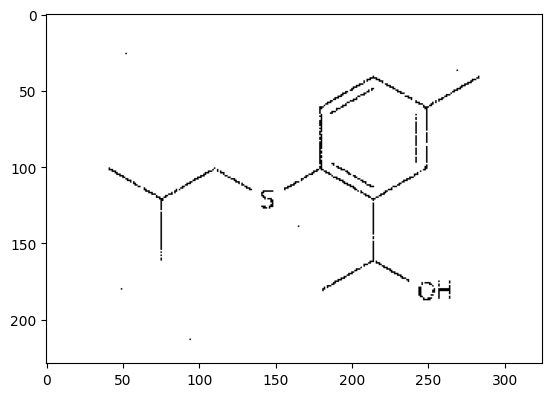

In [202]:
plt.imshow(Image.open(BytesIO(str_to_bytes(results[3]))))

Test Image-Text search

In [204]:
image = Image.open(BytesIO(df['image'].iloc[0]['bytes']))

In [213]:
results2 = search_similarity(
    index=index,
    input=df['image'].iloc[0]['bytes'],
    mode='image',
    top_k=5
)

In [214]:
results2

['InChI=1S/C15H23BrN2O/c1-11(2)17-13-5-4-8-18(10-13)14-9-12(16)6-7-15(14)19-3/h6-7,9,11,13,17H,4-5,8,10H2,1-3H3',
 'InChI=1S/C17H32N2O/c1-5-8-15-18-17(4,7-3)16(20)19(15)14-11-9-13(6-2)10-12-14/h13-15,18H,5-12H2,1-4H3',
 'InChI=1S/C22H20F3N5O2/c1-26-21(32)14-5-3-13(4-6-14)18-12-28-20-19(27-9-2-10-31)29-16-11-15(22(23,24)25)7-8-17(16)30(18)20/h3-8,11-12,31H,2,9-10H2,1H3,(H,26,32)(H,27,29)',
 'InChI=1S/C13H22N2O3/c1-4-14-8-15(7-12(14)16)13(17)11-5-9(2)18-10(3)6-11/h9-11H,4-8H2,1-3H3',
 'InChI=1S/C19H26O2/c1-11-4-12(2)18(17(5-11)21-3)19(20)15-7-13-6-14(9-15)10-16(19)8-13/h4-5,13-16,20H,6-10H2,1-3H3']